In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from visualstoryteller.getonepic import getonepic

['bear', 'strawberries', 'forest']
['goes', 'get']
24576/19212 [======================================] - 0s 1us/step


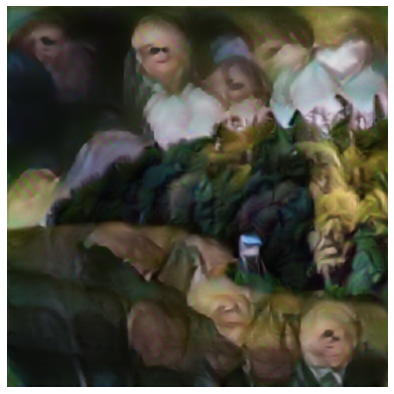

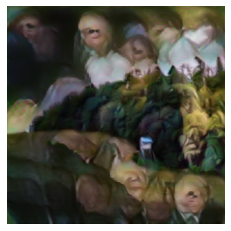

In [3]:
text = "The brown bear goes to get some strawberries to the forest"
result = getonepic(text)
import matplotlib.pyplot as plt
plt.imshow(result['image'][0])
plt.axis(False);


In [6]:
result['style']

['https://images.unsplash.com/photo-1478061653917-455ba7f4a541?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=MXwyMTEyNTd8MHwxfHNlYXJjaHwyMnx8Z2l2ZS1icmluZy1HZXR8ZW58MHx8fA&ixlib=rb-1.2.1&q=80&w=400',
 'Nathan Anderson',
 'https://unsplash.com/@nathananderson']

In [1]:
from visualstoryteller.getmorewords import get_more_words
text = ''
get_more_words(text)

40960/33805 [====================================] - 0s 1us/step


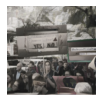

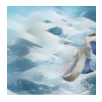

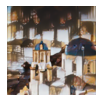

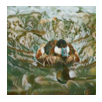

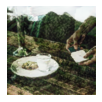

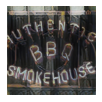

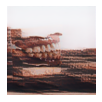

In [1]:
import matplotlib.pyplot as plt
from visualstoryteller.getmorepics_twonouns import getmorepics_twonouns
text = 'dog eat cat on beach run run red sky')
lenn = len(result['image'])
for i in range(lenn):
    plt.subplot(1,lenn,i+1)
    plt.imshow(result['image'][i][0])
    plt.axis(False)

In [5]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

@functools.lru_cache(maxsize=None)
def load_local_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  # image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_url).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


TF Version:  2.4.1
TF-Hub version:  0.11.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  False


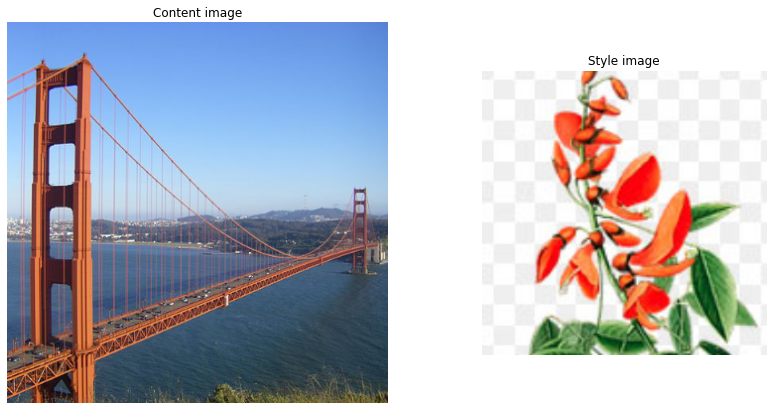

In [12]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = '/Users/ger/code/gerrrd/flower.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_local_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[1,1], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])


In [13]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]


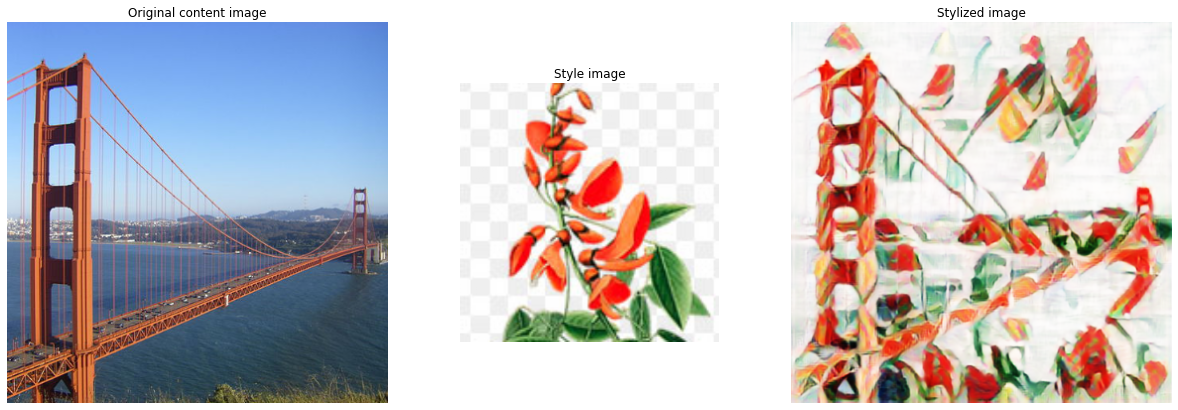

In [14]:
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])


In [ ]:
stylized_image600 = stylized_image

In [14]:
stylezed_image600_style100 = stylized_image

In [22]:
stylezed_image400_style400 = stylized_image

In [1]:
from visualstoryteller.getmorepics import getmorepics
from visualstoryteller.getmorepics_onestyle import getmorepics_onestyle
from visualstoryteller.getmorepics_pattern import getmorepics_pattern
from visualstoryteller.getmorepics_twonouns import getmorepics_twonouns
from visualstoryteller.getonepic import getonepic
text = "The brown bear goes to get some strawberries to the forest"


In [10]:
from visualstoryteller.content import ContentImg
from visualstoryteller.getmorewords import get_more_words

In [6]:
from visualstoryteller.getonepic import getonepic

In [7]:
onepic = getonepic('a cat buys two houses and the mouse has eaten the tree')

32768/32414 [==============================] - 0s 1us/step


In [3]:
from visualstoryteller.mixutils import load_content_image, load_image

In [4]:
link =  'https://pixabay.com/get/g144f247a0371f83494695eb528acc6cde66adf4b58193b67a72a209a61b74c6fed68b3ca8578c74e09d8f35908313dcc_640.jpg'
link2 = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
img = load_content_image(link)

In [5]:
img.shape
# import matplotlib.pyplot as plt
# plt.imshow(img)

TensorShape([1, 256, 256, 3])

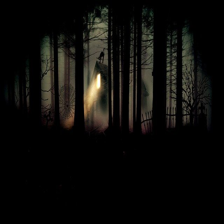

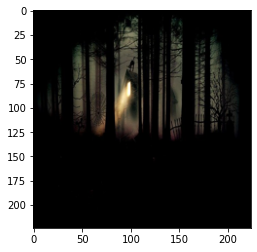

In [26]:
link =  'https://pixabay.com/get/g144f247a0371f83494695eb528acc6cde66adf4b58193b67a72a209a61b74c6fed68b3ca8578c74e09d8f35908313dcc_640.jpg'
# link2 = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}

# load_image(link2)


#         temp_file_name = 'output.jpg'
#         os.system(f'wget {link} --output-document={temp_file_name}')
#         self.content_image = load_local_image('output.jpg', self.content_image_size)
#         os.system(f'rm {temp_file_name}')
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests

r = requests.get(link)
im = Image.open(BytesIO(r.content)).resize((224, 224))
im.size
plt.imshow(im)
# from PIL import Image
# import io
# img = Image.open(io.BytesIO(link)).resize((224, 224))
# io.BytesIO(link)

    
# from skimage import io
# coins = io.imread(link)

# from skimage import io
# coins = io.imread('http://bit.ly/1Du0YsO')
# io.imshow(coins)
# io.show()
im

In [39]:
im.size

(224, 224)

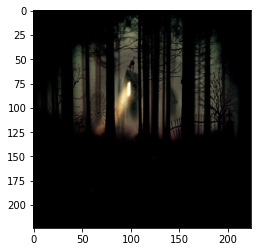

In [67]:
import numpy as np
img = np.array(im).reshape((224,224,3))/255
plt.imshow(img)

In [41]:
import tensorflow as tf

In [43]:
img2 = tf.stack([img, img, img], axis=-1)

In [45]:
img2.shape

TensorShape([224, 224, 3, 3])

In [66]:
img.shape

TensorShape([426, 256, 256, 3])

In [68]:
len(img.shape)

3

In [58]:
img2 = tf.stack([img, img, img])

In [59]:
img2.shape

TensorShape([3, 224, 224, 3])

In [62]:
load_image(link2).shape

TensorShape([1, 256, 256, 3])

In [71]:
np.expand_dims(img,axis=-1).shape

(224, 224, 3, 1)

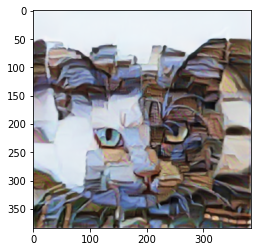

In [12]:
import matplotlib.pyplot as plt
plt.imshow(onepic['image'][0])